In [1]:
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, patches
from scipy import signal
from scipy import stats
from scipy import fftpack
import itertools

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities import utilities as utils

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def apply_notch_60Hz(data, sample_rate):
    '''
    Applies a notch filter to remove 60 Hz line noise.
    
    Inputs:
    -------
    data -- nd.array, (samples, channels)
    sample_rate -- int, Hz
    
    Outputs:
    --------
    filtered_data -- nd.array, (samples, channels)
    '''
    notch_freq = 60

    # initialize filtered signal
    filtered_data = data

    # create filter kernel using firwin
    frange = [notch_freq-0.5, notch_freq+0.5]
    order  = int(150*(sample_rate/frange[0]))
    order  = order + ~order%2

    # filter kernel
    filtkern = signal.firwin(order, frange, pass_zero=True, fs=sample_rate)

    # recursively apply to data
    filtered_data = signal.filtfilt(filtkern, 1, filtered_data, axis=0)
    
    return filtered_data

In [6]:
def rolling_corr(x, y, timestamps, window_length=1000, overlap=500):
    '''
    Calculates the pairwise correlation between x and y in overlapping windows.
    
    Inputs:
    -------
    x, y -- data, 1d array
    timestamps -- timestamps for x, y, 1d array
    window_length -- number of samples to perform correlation over, int (default=1000)
    overlap -- number of samples to overlap, int (default=500)
    
    Outputs:
    --------
    rolling_corr -- correlation of x, y over time
    rolling_pval -- 
    rolling_ts -- 
    '''
    
    # indices of windows
    window_starts = np.arange(0, np.shape(x)[0], window_length-overlap)[:-1]
    
    # initialize arrays
    rolling_corr = np.zeros(len(window_starts))
    rolling_pval = np.zeros(len(window_starts))
    rolling_ts = np.zeros(len(window_starts))
    
    # loop through window_starts and calculate Pearson's correlation
    for ind, beg in enumerate(window_starts):
        end = beg + window_length
        mid = int((beg + end)/2)
        rolling_corr[ind], rolling_pval[ind] = stats.pearsonr(x[beg:end], y[beg:end])
        rolling_ts[ind] = timestamps[mid]
        
    return rolling_corr, rolling_pval, rolling_ts

In [7]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

### Start loading data

In [12]:
dfolder = r'E:\eeg_pilot\mouse497154\pilot2_2020-01-15\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder)
# set the sample_rate for all data analysis
sample_rate = 2500

Aligning timestamps...
Aligned and saved to  E:\eeg_pilot\mouse497154\pilot2_2020-01-15\recording1\continuous\Rhythm_FPGA-111.0\timestamps_master_clock.npy
Loading E:\eeg_pilot\mouse497154\pilot2_2020-01-15\recording1\continuous\Rhythm_FPGA-111.0\continuous.dat
Downsampling data from 10000 Hz to 2500 Hz.


<IPython.core.display.Javascript object>


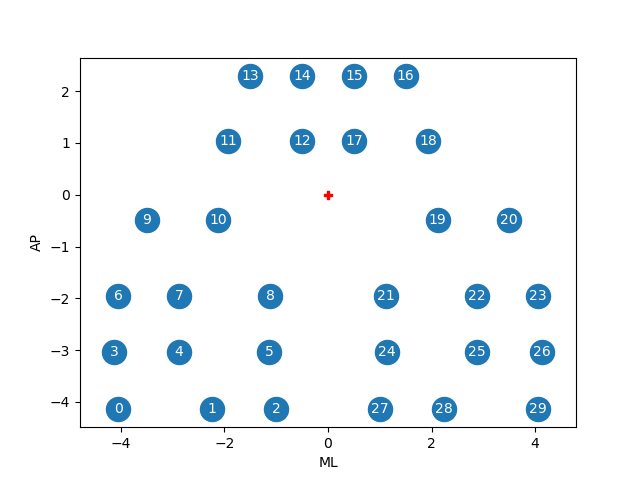

In [9]:
ax = exp.ch_coordinates.plot.scatter(x='ML', y='AP', s=300)
ax.scatter(0, 0, marker='P', color='red')
ax.axis('equal')
    
for ch, coords in exp.ch_coordinates.iterrows():
    ax.annotate(str(ch),  xy=(coords.ML, coords.AP), ha='center', va='center', color="w")

In [9]:
eegdata, timestamps = exp.load_eegdata(frequency=sample_rate, return_type='np')

In [34]:
eegdata = eegdata * exp.bits_to_uvolts

In [10]:
print(np.shape(eegdata))
print('Recording duration: %0.1f minutes' % (np.shape(eegdata)[0]/sample_rate/60))

(6987264, 32)
Recording duration: 46.6 minutes


#### Notch filter the eeg data

In [11]:
filteeg = apply_notch_60Hz(eegdata, sample_rate)
print(np.shape(filteeg))

(6987264, 32)


#### Lowpass filter the eeg data

<IPython.core.display.Javascript object>


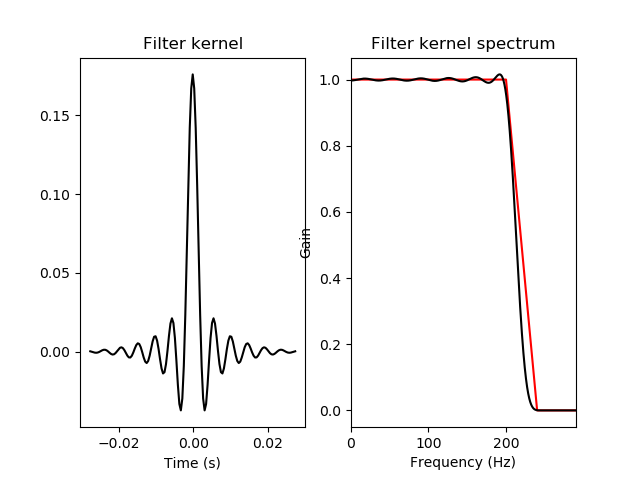

In [12]:
# design and check the lowpass filter kernel
filter_kernel = lowpass_filt_design(len(timestamps),
                                    sample_rate,
                                    cutoff_freq=200,
                                    trans_width=0.2,
                                    order_multiple=11,
                                    plot_kern=True)

In [13]:
# apply filter to notch filtered data
filteeg = signal.filtfilt(filter_kernel, 1, filteeg, axis=0)

#### Plot two channels to look at 60 Hz noise

In [14]:
common_avg_ref = np.mean(eegdata, axis=1)
print(np.shape(common_avg_ref))

(6987264,)


<IPython.core.display.Javascript object>


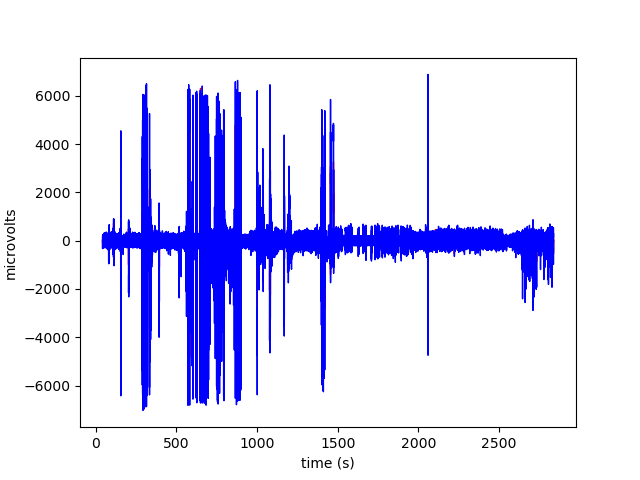

Text(0, 0.5, 'microvolts')

In [16]:
fig, ax = plt.subplots()

# raw data
# ax.plot(timestamps, eegdata[:,1], 'r', linewidth=1)
# ax.plot(timestamps, eegdata[:,9], 'b', linewidth=1)
# ax.plot(timestamps, eegdata[:,12], 'c', linewidth=1)
# ax.plot(timestamps, eegdata[:,22], 'g', linewidth=1)

# filtered data
ax.plot(timestamps, filteeg[:,1], 'r', linewidth=1)
ax.plot(timestamps, filteeg[:,9], 'b', linewidth=1)

# common avg raw
# ax.plot(timestamps, common_avg_ref, 'k', linewidth=1.5)

ax.set_xlabel('time (s)')
ax.set_ylabel('microvolts')

### How correlated are any two channels? Does this have a dependence on distance? And how does the correlation vary over time?

In [33]:
cha = 1
chb = 3

In [34]:
exp.ch_coordinates.head()

,AP,ML
0,-4.14,-4.05
1,-4.14,-2.24
2,-4.14,-1.00
3,-3.04,-4.13
4,-3.04,-2.88


In [35]:
dist_ab = np.sqrt((exp.ch_coordinates.AP.iloc[cha]-exp.ch_coordinates.AP.iloc[chb])**2 + (exp.ch_coordinates.ML.iloc[cha]-exp.ch_coordinates.ML.iloc[chb])**2)
print('Distance (ch %d to %d) is %0.2f mm' % (cha, chb, dist_ab))

Distance (ch 1 to 3) is 2.19 mm


In [36]:
orig_r, orig_pvalue = stats.pearsonr(eegdata[:,cha], eegdata[:,chb])
print('Pearson r: %0.3f' % orig_r)
print('p-value: %0.5f' % orig_pvalue)

Pearson r: 0.528
p-value: 0.00000


In [37]:
filt_r, filt_pvalue = stats.pearsonr(filteeg[:,cha], filteeg[:,chb])
print('After notch filter:')
print('Pearson r: %0.3f' % filt_r)
print('p-value: %0.5f' % filt_pvalue)

After notch filter:
Pearson r: 0.223
p-value: 0.00000


In [38]:
rolling_r, rolling_p, rolling_ts = rolling_corr(filteeg[:,cha], filteeg[:,chb], timestamps)

<IPython.core.display.Javascript object>


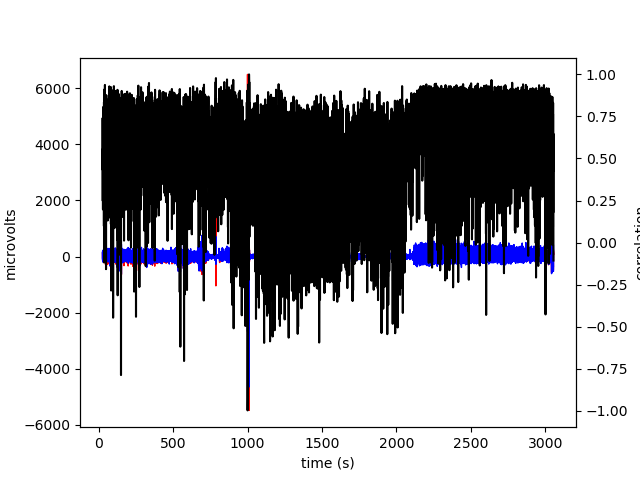

Text(0, 0.5, 'correlation')

In [39]:
fig, ax = plt.subplots()

ax.plot(timestamps, filteeg[:,cha], 'r', linewidth=1)
ax.plot(timestamps, filteeg[:,chb], 'b', linewidth=1)

ax_corr = ax.twinx()
ax_corr.plot(rolling_ts, rolling_r, 'k', linewidth=1.5)

ax.set_xlabel('time (s)')
ax.set_ylabel('microvolts')
ax_corr.set_ylabel('correlation')

#### Loop through all unique electrode pairs.

In [17]:
ch_a = []
ch_b = []
dist = []
pearson_r = []
p_value = []
filt_r = []
filt_pvalue = []

for a, b in itertools.combinations(exp.ch_coordinates.index.values, 2):
    ch_a.append(a)
    ch_b.append(b)
    
    # calculate distance between ch a and b
    dist.append(np.sqrt((exp.ch_coordinates.AP.iloc[a]-exp.ch_coordinates.AP.iloc[b])**2
                        + (exp.ch_coordinates.ML.iloc[a]-exp.ch_coordinates.ML.iloc[b])**2))
    
    # calculate the Pearson's correlation between the EEG data for ch a and b
    temp_r, temp_p = stats.pearsonr(eegdata[:,a], eegdata[:,b])
    pearson_r.append(temp_r)
    p_value.append(temp_p)
    
    # calculate the Pearson's correlation between the notch-filtered data for ch a and b
    f_r, f_p = stats.pearsonr(filteeg[:,a], filteeg[:,b])
    filt_r.append(f_r)
    filt_pvalue.append(f_p)
    
# make into dataframe?
ch_combos = pd.DataFrame({
    'ch_a': ch_a,
    'ch_b': ch_b,
    'distance': dist,
    'pearson_r': pearson_r,
    'p_value': p_value,
    'filtered_r': filt_r,
    'filtered_p': filt_pvalue
})

In [18]:
ch_combos.head()

,ch_a,ch_b,distance,pearson_r,p_value,filtered_r,filtered_p
0,0,1,1.810000,0.444824,0.0,0.113330,0.0
1,0,2,3.050000,0.377686,0.0,0.126651,0.0
2,0,3,1.102905,0.697438,0.0,0.336878,0.0
3,0,4,1.605895,0.652399,0.0,0.388902,0.0
4,0,5,3.120320,0.392832,0.0,0.015111,0.0


<IPython.core.display.Javascript object>


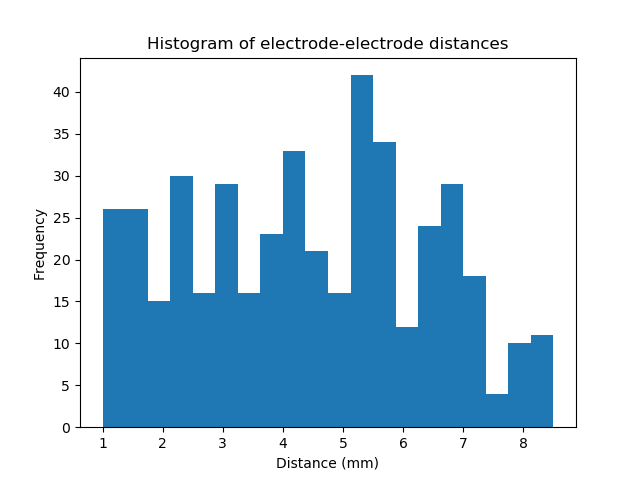

Text(0.5, 1.0, 'Histogram of electrode-electrode distances')

In [58]:
fig = plt.figure()
ax = ch_combos['distance'].plot.hist(bins=20)
ax.set_xlabel('Distance (mm)')
ax.set_title('Histogram of electrode-electrode distances')

<IPython.core.display.Javascript object>


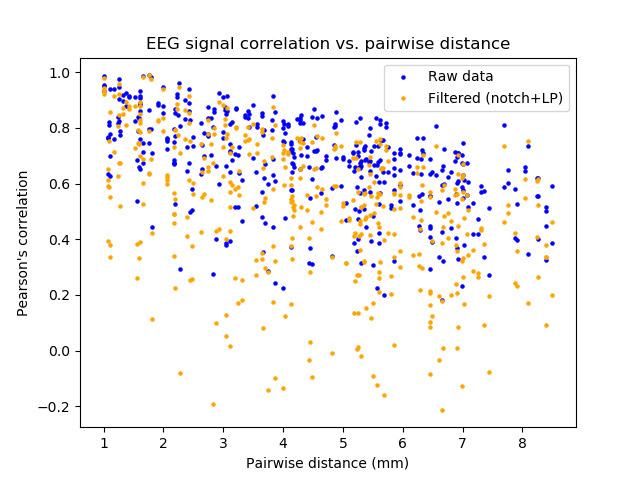

Text(0.5, 1.0, 'EEG signal correlation vs. pairwise distance')

In [32]:
ax = ch_combos.plot.scatter(x='distance', y='pearson_r', s=5, c='b', label='Raw data')
ch_combos.plot.scatter(x='distance', y='filtered_r', s=5, c='orange', label='Filtered (notch+LP)', ax=ax)
ax.set_ylabel("Pearson's correlation")
ax.set_xlabel('Pairwise distance (mm)')
ax.set_title('EEG signal correlation vs. pairwise distance')

Ethan made a interesting comment that the 60 Hz noise could be causing an artificially high correlation between electrodes. Could try filtering the signals prior to correlation.

In [20]:
mean_corr, dist_bin, binnumber = stats.binned_statistic(ch_combos.distance.to_numpy(),
                                                        ch_combos.filtered_r.to_numpy(),
                                                        statistic='mean',
                                                        bins=10
                                                       )
std_corr, db, bn = stats.binned_statistic(ch_combos.distance.to_numpy(),
                                          ch_combos.filtered_r.to_numpy(),
                                          statistic='std',
                                          bins=10
                                         )

Calculate linear regression of distance and correlation:

In [22]:
drslope, drintercept, drrval, drpval, drste = stats.linregress(ch_combos.distance.to_numpy(), ch_combos.filtered_r.to_numpy())

In [24]:
print('Linear regression r value: %0.2f' % drrval)
print('Linear regression p value: %0.2f' % drpval)

Linear regression r value: -0.43
Linear regression p value: 0.00


<IPython.core.display.Javascript object>


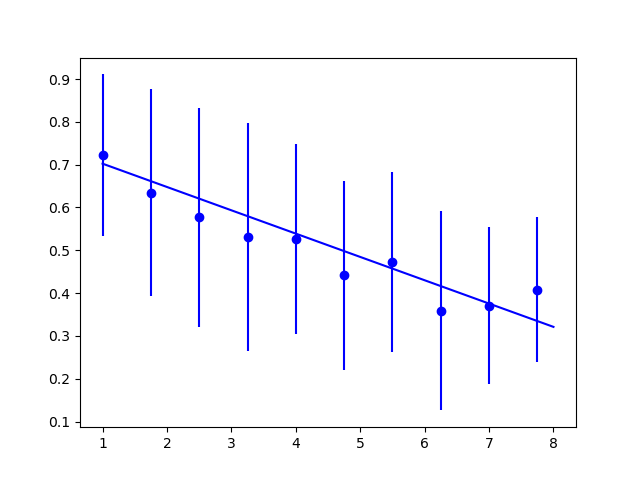

In [23]:
fig, ax = plt.subplots()

ax.errorbar(dist_bin[:-1], mean_corr, yerr=std_corr, fmt='bo')

# plot linear regression
xdist = np.arange(dist_bin[0], dist_bin[-1])
ax.plot(xdist, drslope*xdist+drintercept, 'b-')

### Let's apply a lowpass filter to see if it changes correlation

<IPython.core.display.Javascript object>


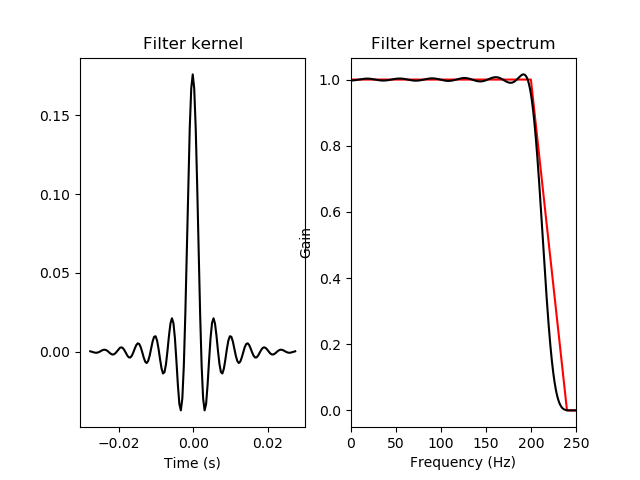

Text(0.5, 1.0, 'Filter kernel spectrum')

In [68]:
npnts = len(timestamps)
hz = np.linspace(0, sample_rate/2, int(np.floor(npnts/2)+1))

## now for lowpass filter
fcutoff = 200
transw = 0.2
order = np.round(11*sample_rate/fcutoff)+1

shape = [1,1,0,0]
frex = [0, fcutoff, fcutoff+fcutoff*transw, sample_rate/2]

# filter kernel
filtkern = signal.firls(order, frex, shape, fs=sample_rate)

# its power spectrum
filtkernX = np.abs(fftpack.fft(filtkern, npnts))**2

fig, axs = plt.subplots(1, 2)
axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Filter kernel')

axs[1].plot(np.array(frex), shape, 'r')
axs[1].plot(hz, filtkernX[:len(hz)], 'k')
axs[1].set_xlim([0, 250])
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Gain')
axs[1].set_title('Filter kernel spectrum')

<IPython.core.display.Javascript object>


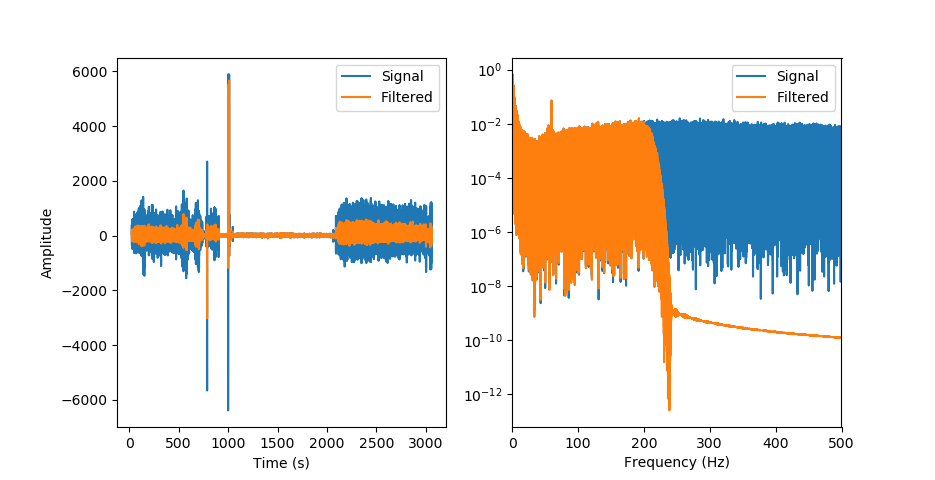

Text(0.5, 0, 'Frequency (Hz)')

In [69]:
chch = 0
### now apply the filter to the data
lpfilt_ch = signal.filtfilt(filtkern, 1, eegdata[:,chch])

fig, axs = plt.subplots(1, 2)
axs[0].plot(timestamps, eegdata[:,chch], label='Signal')
axs[0].plot(timestamps, lpfilt_ch, label='Filtered')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].legend()

### power spectra of original and filtered signal
yOrigX = np.abs(fftpack.fft(eegdata[:,chch])/npnts)**2
yFiltX = np.abs(fftpack.fft(lpfilt_ch)/npnts)**2

axs[1].semilogy(hz, yOrigX[:len(hz)], label='Signal')
axs[1].semilogy(hz, yFiltX[:len(hz)], label='Filtered')
axs[1].set_xlim([0, sample_rate/5])
axs[1].legend()
axs[1].set_xlabel('Frequency (Hz)')

### Let's use some code from the Signal Processing course to apply a notch filter to remove line noise and some of it's harmonics.

In [9]:
# load data
data  = eegdata[:,2]*exp.bits_to_uvolts
srate = 2500

# time vector
pnts = len(data)
time = np.arange(0,pnts)/srate
time = time.T

# compute power spectrum and frequencies vector
pwr = np.abs(fftpack.fft(data)/pnts)**2
hz  = np.linspace(0,srate,pnts)


# ### plotting
# fig = plt.figure()
# # time-domain signal
# plt.subplot(121)
# plt.plot(time[0:-1:1000],data[0:-1:1000],'k')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Time domain')

# # plot power spectrum
# plt.subplot(122)
# plt.plot(hz,pwr,'k')
# plt.xlim([0,400])
# plt.ylim([0,2])
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power')
# plt.title('Frequency domain')
# plt.show()

<IPython.core.display.Javascript object>


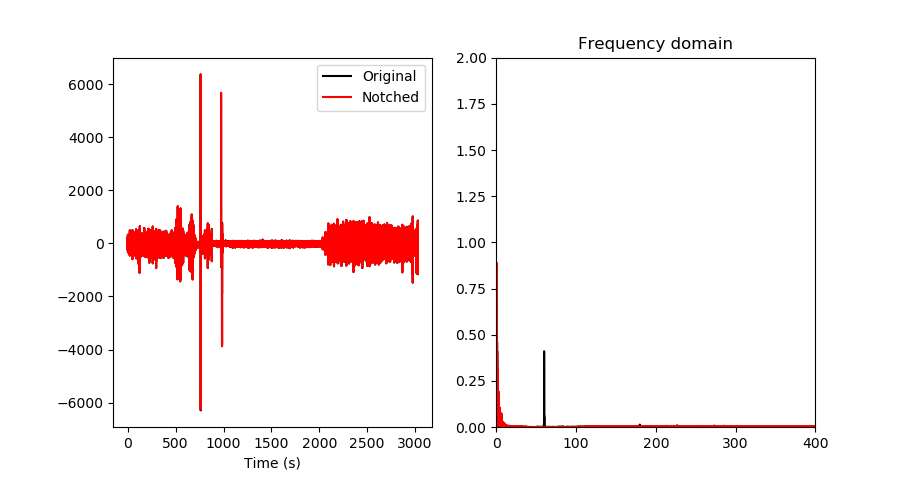

In [10]:
## narrowband filter to remove line noise

frex2notch = [ 60, 180 ]

# initialize filtered signal
datafilt = data

# loop over frequencies
for fi in range(0,len(frex2notch)):
    
    # create filter kernel using firwin (fir1 in MATLAB)
    frange = [frex2notch[fi]-.5, frex2notch[fi]+.5]
    order  = int( 150*(srate/frange[0]) )
    order  = order + ~order%2
    
    # filter kernel
    filtkern = signal.firwin( order,frange,pass_zero=True,fs=srate )
    
#     # visualize the kernel and its spectral response
#     plt.subplot(121)
#     plt.plot(filtkern)
#     plt.title('Time domain')
    
#     plt.subplot(122)
#     plt.plot(np.linspace(0,srate,10000),np.abs(fftpack.fft(filtkern,10000))**2)
#     plt.xlim([frex2notch[fi]-30, frex2notch[fi]+30])
#     plt.title('Frequency domain')
#     plt.show()
    
    # recursively apply to data
    datafilt = signal.filtfilt(filtkern,1,datafilt)
    
fig = plt.figure()
### plot the signal
plt.subplot(121)
plt.plot(time,data,'k',label='Original')
plt.plot(time,datafilt,'r',label='Notched')
plt.xlabel('Time (s)')
plt.legend()


# compute the power spectrum of the filtered signal
pwrfilt = np.abs(fftpack.fft(datafilt)/pnts)**2

# plot power spectrum
plt.subplot(122)
plt.plot(hz,pwr,'k',label='Original')
plt.plot(hz,pwrfilt,'r',label='Notched')
plt.xlim([0,400])
plt.ylim([0,2])
plt.title('Frequency domain')
plt.show()